In [2]:
# Necessary Packages

from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
import time
import os
import zipfile

In [ ]:
# Download all zip files of hourly data with selenium
driver = webdriver.Chrome()

# Access the website
driver.get("https://www.ercot.com/gridinfo/load/load_hist")

table = driver.find_element(By.XPATH, "//div[@id='details-70372353-7ccc-4458-b9d8-ebb5841796c0']")
years = table.find_elements(By.XPATH, ".//div[@name='section-components']")

for year in years:

    zip_divs = year.find_elements(By.XPATH, ".//div[@class='col-12 col-md']//a")

    for zip_div in zip_divs:

        if int(zip_div.text[0:5]) >= 2002:  # Only getting data from 2002 onwards since 2001 data is missing.

            href_value = zip_div.get_attribute("href")
            zip_div.click()
            time.sleep(5)

In [2]:
# After moving data in directory of your choice, we want to put all of our results into one df.

full_data = pd.DataFrame(columns = ['Hour Ending', 
                                    'Coast', 
                                    'East', 
                                    'Far West', 
                                    'North', 
                                    'North Central', 
                                    'South', 
                                    'South Central', 
                                    'West', 
                                    'ERCOT'])

for file in os.listdir("C:\\Users\\Tripathy\\Documents\\Books\\Python\\Time Series Analysis\\HourlyData"):

    current_year_data = None

    if '.xls' in file:
        print(f'Reading: {file}')
        current_year_data = pd.read_excel(f"C:\\Users\\Tripathy\\Documents\\Books\\Python\\Time Series Analysis\\HourlyData\\{file}")
        current_year_data.columns = full_data.columns
        

    elif '.zip' in file:
        with zipfile.ZipFile(f"C:\\Users\\Tripathy\\Documents\\Books\\Python\\Time Series Analysis\\HourlyData\\{file}", 'r') as zip_file:

            files_in_zip = zip_file.namelist()

            for file_name in files_in_zip:
                if file_name.endswith('.xlsx'):
                    print(f'Reading: {file_name}')

                    with zip_file.open(file_name) as excel_file:

                        current_year_data = pd.read_excel(excel_file)
                        current_year_data.columns = full_data.columns
    
    
    full_data = pd.concat([full_data, current_year_data])


Reading: 2002_ercot_hourly_load_data.xls
Reading: 2003_ercot_hourly_load_data.xls


C:\Users\Tripathy\AppData\Local\Temp\ipykernel_2008\4038173682.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_data = pd.concat([full_data, current_year_data])


Reading: 2004_ercot_hourly_load_data.xls
Reading: 2005_ercot_hourly_load_data.xls
Reading: 2006_ercot_hourly_load_data.xls
Reading: 2007_ercot_hourly_load_data.xls
Reading: 2008_ercot_hourly_load_data.xls
Reading: 2009_ercot_hourly_load_data.xls
Reading: 2010_ercot_hourly_load_data.xls
Reading: 2011_ercot_hourly_load_data.xls
Reading: 2012_ercot_hourly_load_data.xls
Reading: 2013_ercot_hourly_load_data.xls
Reading: 2014_ercot_hourly_load_data.xls
Reading: native_load_2015.xls
Reading: native_Load_2016.xlsx
Reading: native_Load_2017.xlsx
Reading: Native_Load_2018.xlsx
Reading: Native_Load_2019.xlsx
Reading: Native_Load_2020.xlsx
Reading: Native_Load_2021.xlsx
Reading: Native_Load_2022.xlsx
Reading: Native_Load_2023.xlsx
Reading: Native_Load_2024.xlsx


In [3]:
# Some of our times are really have extended hh:mm:ss, and some rows have differen y/m/d formats.
# This script is meant to clean the data, and then put the cleaned data into a CSV.
full_data.index = range(len(full_data))

def reformat_time(x):
    
    if not isinstance(x, str):
        return pd.to_datetime(x - pd.Timedelta(seconds = 1))
    
    else:
        time_string = x[0:11]

        if x[11] == '0':
            time_string += '0' + str(int(x[11:13]) - 1)

        elif x[11:13] == '10':
            time_string += '09'

        else:
            time_string += str(int(x[11:13]) - 1)

        time_string += ':59:59'

        return pd.to_datetime(time_string, format = "%m/%d/%Y %H:%M:%S")
    
full_data['Hour Ending'] = full_data['Hour Ending'].apply(lambda x: reformat_time(x))
full_data['Date'] = full_data['Hour Ending'].apply(lambda x: str(x)[0:10])
full_data['HE'] = full_data['Hour Ending'].apply(lambda x: int(str(x)[11:13]) + 1)

full_data = full_data.rename(columns = {'Hour Ending':'DateTime', 
                                        'HE':'Hour Ending'})

full_data.to_csv('HourlyERCOTData.csv', index=False) 

In [3]:
# Once we run the selenium and zipfile script, we can just access the data through the csv file we created.
df = pd.read_csv('HourlyERCOTData.csv', header = 0)
df['DateTime'] = pd.to_datetime(df['DateTime'], format = "ISO8601")
df

,DateTime,Coast,East,Far West,North,North Central,South,South Central,West,ERCOT,Date,Hour Ending
0,2002-01-01 00:59:59.003,8331.469266,1111.096549,1094.045496,995.298392,10336.304899,2165.007571,4793.193560,843.747177,29670.162911,2002-01-01,1
1,2002-01-01 01:59:58.997,8107.805431,1091.481584,1083.517981,981.195477,10178.052738,2092.374118,4766.918187,835.488188,29136.833703,2002-01-01,2
2,2002-01-01 02:59:59.000,7890.721717,1080.257616,1085.038740,971.305257,10100.887710,2042.080714,4702.918892,830.694878,28703.905525,2002-01-01,3
3,2002-01-01 03:59:59.003,7799.817527,1079.726403,1093.381853,971.262963,10081.565109,2011.935791,4669.064391,835.068413,28541.822450,2002-01-01,4
4,2002-01-01 04:59:58.997,7815.968171,1087.934961,1106.651296,982.535591,10192.218670,2002.487678,4695.011904,848.598209,28731.406478,2002-01-01,5
...,...,...,...,...,...,...,...,...,...,...,...,...
195018,2024-03-31 19:59:59.000,12861.538998,1606.001310,6369.117950,1194.385911,12596.268392,4204.039428,7913.461050,1300.901689,48045.714727,2024-03-31,20
195019,2024-03-31 20:59:59.000,13008.863337,1620.109978,6401.703793,1229.065085,13002.992588,4218.623012,8089.728213,1317.653223,48888.739229,2024-03-31,21
195020,2024-03-31 21:59:59.000,12948.139007,1587.879065,6356.533465,1219.858492,12843.154987,4187.083354,7962.281681,1296.010360,48400.940411,2024-03-31,22
195021,2024-03-31 22:59:59.000,12552.698541,1481.072355,6323.245205,1177.297905,12230.101142,4057.512091,7604.930665,1240.800077,46667.657982,2024-03-31,23


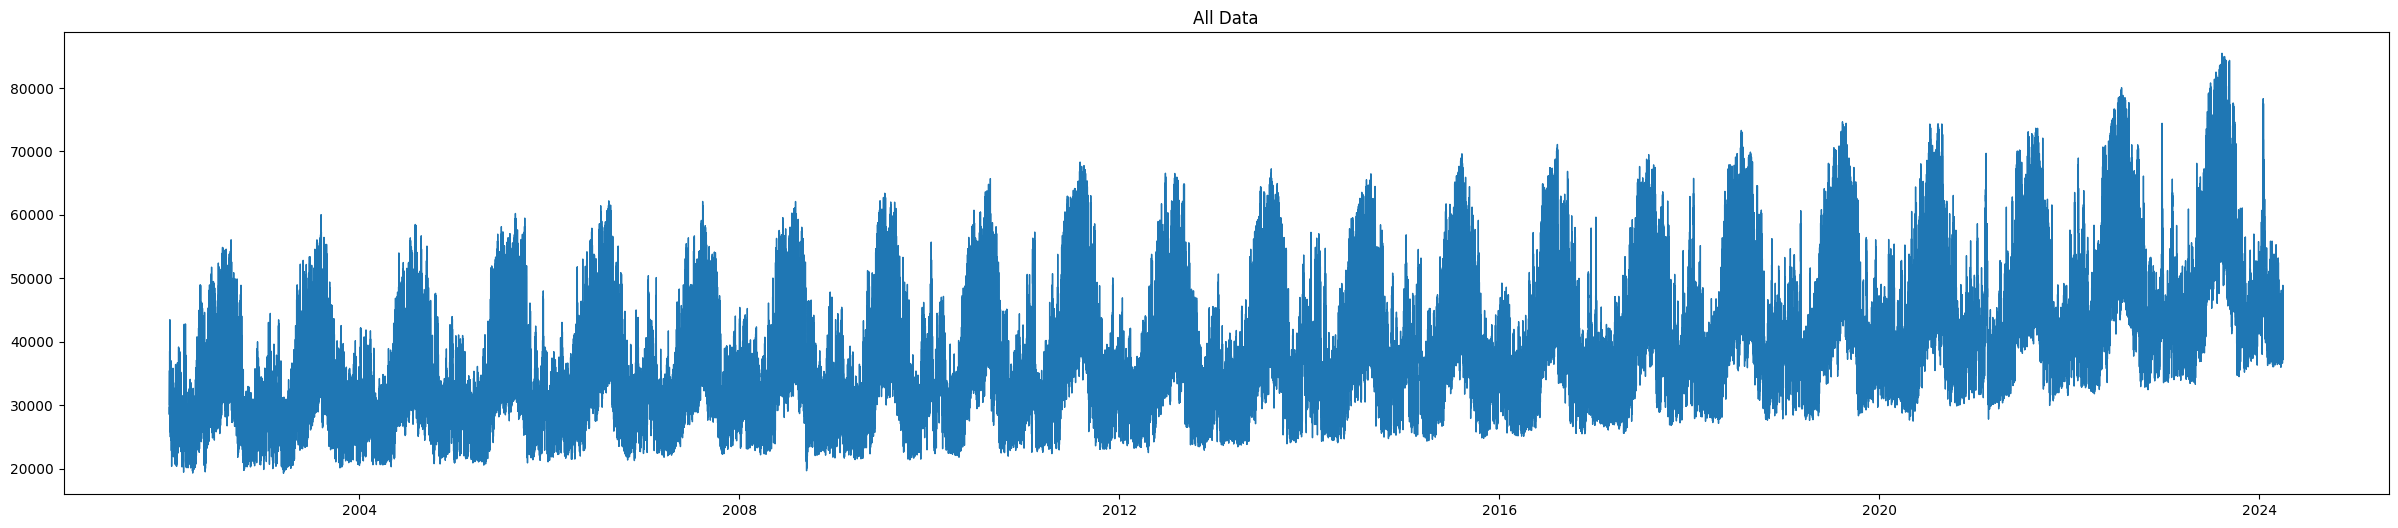

8760


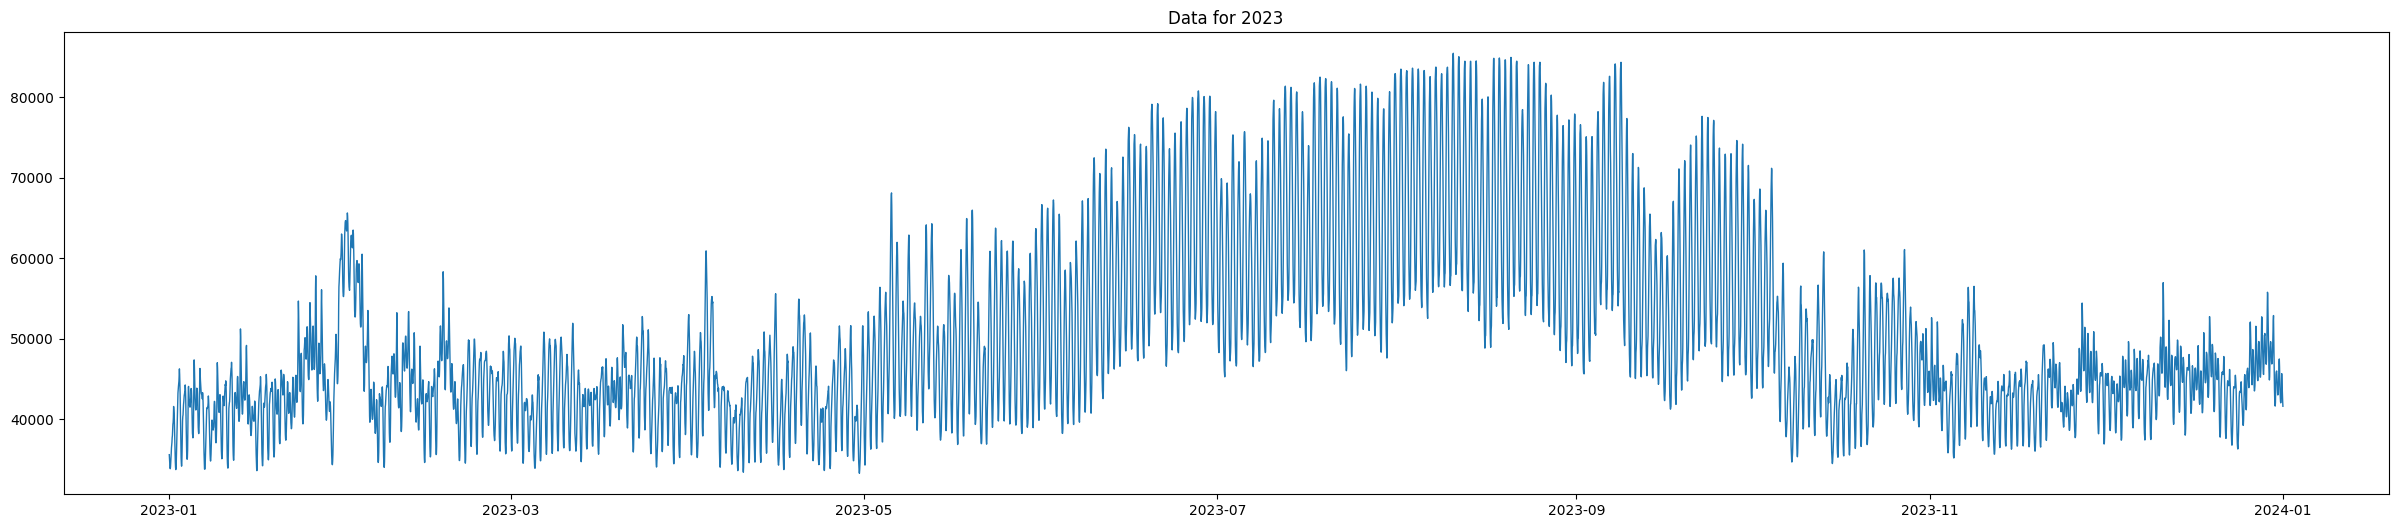

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30,6))
plt.plot(df['DateTime'], df['ERCOT'], linewidth = 1)
plt.title('All Data')
plt.show()

data_2023 = df[df['DateTime'].dt.year == 2023]
print(len(data_2023))
fig = plt.figure(figsize=(30,6))
plt.plot(data_2023['DateTime'], data_2023['ERCOT'], linewidth = 1)
plt.title('Data for 2023')
plt.show()